Codificador Rice

In [10]:
from bitstring import BitArray, pack
import numpy as np
from PIL import Image
import struct
import matplotlib.pyplot as plt


def rice_encode(e, m):
    """
    Codifica el entero e usando código Rice-m.
    Retorna un BitArray con la secuencia de bits resultante.
    """
    # 1) Transformación e -> e'
    if e >= 0:
        e_prime = 2 * e
    else:
        e_prime = 2 * abs(e) - 1

    # 2) eq, er
    eq = e_prime >> m  # eq = floor(e'/2^m)
    er = e_prime & ((1 << m) - 1)  # er = e' mod 2^m (resto)

    # 3) eq en unario => eq ceros + '1'
    #    Por ejemplo si eq=3 => '0001'
    codigo_unario = "0" * eq + "1"

    # 4) er en binario fijo de m bits
    #    Formateamos er como un string binario de longitud m
    codigo_fijo = format(er, "0{}b".format(m))

    # 5) concatenamos
    code_str = codigo_unario + codigo_fijo

    # Convertimos a BitArray
    return BitArray(bin=code_str)


def rice_decode(bitstream, m, pos_inicial=0):
    """
    Decodifica un entero e desde bitstream, asumiendo
    que en pos_inicial empieza el código Rice-m de e.
    Retorna (e, pos_final).
    """
    pos = pos_inicial

    # 1) eq = número de ceros hasta primer '1'
    eq = 0
    while bitstream[pos] == 0:
        eq += 1
        pos += 1
    # cuando salimos, bitstream[pos] == 1
    pos += 1  # saltamos el '1'

    # 2) leemos m bits => er
    er_bits = bitstream[pos : pos + m]
    pos += m
    er = er_bits.uint  # interpretamos como entero sin signo

    # 3) e' = eq * 2^m + er
    e_prime = (eq << m) + er

    # 4) e = ?
    if (e_prime % 2) == 0:
        # e_prime par => e >= 0
        e = e_prime >> 1
    else:
        # e_prime impar => e < 0
        e = -((e_prime + 1) >> 1)

    return e, pos

Codificación predictiva sin perdidas


In [11]:
def codPred(nombreI, nombreS, m):
    """
    Codifica sin pérdidas la imagen en 'nombreI' usando predictor de primera diferencia
    y código Rice(m) para e[n] (excepto la primera muestra, que codificamos en 8 bits fijos).
    Guarda la secuencia de bits en 'nombreS'.

    Cabecera (por simplicidad):
      - 16 bits: f
      - 16 bits: c
      - 8 bits: m
    """
    # 1) Leer imagen en gris
    im = Image.open(nombreI).convert("L")  # 'L' => 8 bits/píxel
    xmat = np.array(im, dtype=np.int32)  # en [0..255]
    f, c = xmat.shape
    N = f * c

    # 2) Flatten row-major (exploración raster) => vector x
    x = xmat.flatten()  # x[0], x[1], ..., x[N-1]

    # 3) BitArray para ir almacenando los bits
    bitstream = BitArray()

    # 3a) Escribimos cabecera en binario (16 bits f, 16 bits c, 8 bits m)
    #     Podemos usar struct para f y c (uint16) y un byte para m
    #     y luego meterlo en bitstream
    cabecera_bin = struct.pack(
        "<HHB", f, c, m
    )  # little-endian: 2 bytes f, 2 bytes c, 1 byte m
    bitstream += BitArray(bytes=cabecera_bin)

    # 4) Bucle principal
    x_1 = 0  # x[-1] ficticio
    for n in range(N):
        e = x[n] - x_1
        if n == 0:
            # codificar e[0] con 8 bits fijos => por ejemplo signed int8 (¡ojo con overflow!)
            # Para simplificar, lo ajustamos a un rango -128..127
            e_clip = np.clip(e, -128, 127).astype(np.int8)
            # convertimos e_clip a 8 bits
            bitstream += BitArray(int=e_clip, length=8)
        else:
            # Rice-m
            e_bits = rice_encode(e, m)
            bitstream += e_bits

        x_1 = x[n]

    # 5) Guardar bitstream en fichero
    with open(nombreS, "wb") as f_out:
        bitstream.tofile(f_out)

    print(
        f"[codPred] Fichero '{nombreS}' generado. Imagen {f}x{c}, m={m}, muestras={N}."
    )
    print(f"Tamaño final: {len(bitstream)} bits (~ {len(bitstream)//8} bytes).")

Decodificador decPred

[codPred] Fichero 'i1_pred.bin' generado. Imagen 708x512, m=3, muestras=362496.
Tamaño final: 2135654 bits (~ 266956 bytes).
[decPred] Decodificado i1_pred.bin: 50178x2, m=3, 100356 muestras.


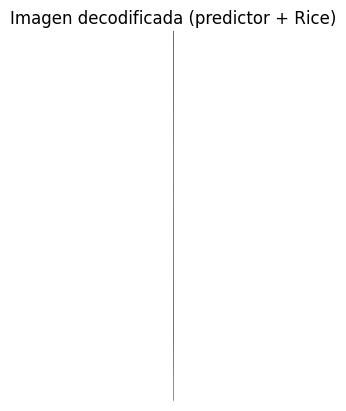

In [ ]:
def decPred(nombreS):
    """
    Decodifica el fichero 'nombreS' generado con codPred.
    Retorna la imagen decodificada como un numpy array (f,c) de int32
    (o si prefieres, np.uint8, con clipping).
    """
    # Cargamos todo el bitstream del fichero
    with open(nombreS, "rb") as f_in:
        data = f_in.read()

    bitstream = BitArray(data)

    # 1) Leemos cabecera: 16 bits f, 16 bits c, 8 bits m
    pos = 0
    f = bitstream[pos : pos + 16].uint  # uint16
    pos += 16
    c = bitstream[pos : pos + 16].uint
    pos += 16
    m = bitstream[pos : pos + 8].uint  # 8 bits
    pos += 8

    N = f * c

    x = np.zeros(N, dtype=np.int32)

    # 2) Leer la primera muestra (8 bits signed)
    e0_bits = bitstream[pos : pos + 8]
    pos += 8
    e0 = e0_bits.int  # interpreta esos 8 bits como entero con signo
    x[0] = e0  # x[0] = e[0] + x[-1]=0 => e[0]

    # 3) Bucle para n=1..N-1
    for n in range(1, N):
        # decodificar un Rice-m
        e_n, pos = rice_decode(bitstream, m, pos)
        x[n] = x[n - 1] + e_n

    # 4) Reconstruimos la imagen
    xmat = x.reshape((f, c))

    print(f"[decPred] Decodificado {nombreS}: {f}x{c}, m={m}, {N} muestras.")
    return xmat


def ejemplo_pred():
    # Codificar i1.png con m=3
    codPred("../data/i1.png", "i1_pred.bin", m=3)

    # Decodificar
    x_dec = decPred("i1_pred.bin")

    # Convertir a uint8
    x_dec_u8 = np.clip(x_dec, 0, 255).astype(np.uint8)

    # Guardar en disco
    im_rec = Image.fromarray(x_dec_u8, mode="L")
    im_rec.save("i1_rec.png")

    # O mostrar en pantalla

    plt.imshow(x_dec_u8, cmap="gray")
    plt.title("Imagen decodificada (predictor + Rice)")
    plt.axis("off")
    plt.show()


ejemplo_pred()